# 024 UK_lineages (almost) exclusive to Norwich

This notebook is an example of how to generate a map from COG-UK data. It aggregates information from two geographical levels: if postcode information is available (`adm2_private`) then it uses it; otherwise it tries the `adm2` (equivalent to [NUTS2](https://en.wikipedia.org/wiki/NUTS_statistical_regions_of_the_United_Kingdom)) but reweighted to indicate uncertainty.

**Not real data:** The metadata has only randomly generated private information (postcode, amd2, age, sex, etc.) due to confidentiality concerns. As a consequence, unlike the real data sets, there is no association between UK lineages and their geographical location here. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display    
import peroba

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from matplotlib import rcParams, cm, colors, patches
from mpl_toolkits.basemap import Basemap 

from sklearn.neighbors import NearestNeighbors, BallTree ## KDTree does NOT accept hamming
from sklearn.cluster import OPTICS
import pandas as pd, numpy as np, geopandas as gpd
import re, collections

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 6
pd.options.display.max_columns = 32

In [2]:
df0 = pd.read_csv("fake_metadata.csv",dtype='unicode', index_col="peroba_seq_uid")
df = df0[ df0["adm2"].str.contains("Norfolk", flags=re.IGNORECASE, na=False) ]
df = df.dropna(axis=0, subset=["uk_lineage"])
display(df)
x = df["uk_lineage"].unique()
display(collections.Counter(df["uk_lineage"]).most_common(5))

,sequence_name,central_sample_id,adm0,adm1,adm2,adm2_private,lineage,lineage_support,uk_lineage,phylotype,source_age,source_sex,collection_date,country,submission_org_code
peroba_seq_uid,,,,,,,,,,,,,,,
England/CAMB-1AA2A7/2020,England/CAMB-1AA2A7/2020,CAMB-1AA2A7,UK,UK-ENG,Norfolk,NR13,B.1,86.0,UK2916,UK2916_1.18,0.0,M,2020-03-29,UK,CAMB
England/CAMB-1AA2B6/2020,England/CAMB-1AA2B6/2020,CAMB-1AA2B6,UK,UK-ENG,Norfolk,PE37,B.1.13,99.0,UK9,UK9_1.15,25.0,M,2020-03-23,UK,CAMB
England/CAMB-1AA2C5/2020,England/CAMB-1AA2C5/2020,CAMB-1AA2C5,UK,UK-ENG,Norfolk,IP22,B.1.1.1,100.0,UK468,UK468_1.3,99.0,M,2020-04-03,UK,CAMB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NORW-EE967,NORW-EE967,NORW-EE967,NaN,UK-ENG,Norfolk,NR5,B.1,NaN,UK42,UK42_1.64.1.2,50.0,M,2020-03-20,NaN,NORW
NORW-EE985,NORW-EE985,NORW-EE985,NaN,UK-ENG,Norfolk,PE14,B.1.1,NaN,UK2735,UK2735_1.4.2.1,32.0,F,2020-04-30,NaN,NORW
NORW-EEA0A,NORW-EEA0A,NORW-EEA0A,NaN,UK-ENG,Norfolk,NR8,B.1,NaN,UK5741,UK5741_1,23.0,F,2020-04-03,NaN,NORW


[('UK2735', 310),
 ('UK9', 309),
 ('UK494', 304),
 ('UK2913', 299),
 ('UK167', 297)]

In [3]:
tableau = list()
for lin in x:
    df_lin = df0[ df0["uk_lineage"].str.match(lin, na=False) ]
    n_lin = df_lin.shape[0]
    if n_lin > 1:
        n_nor = len(df_lin[ df_lin["adm2"].str.contains("Norfolk", flags=re.IGNORECASE, na=False) ])
        tableau.append([lin, n_nor, n_lin, n_nor/n_lin])
t_sort = sorted(tableau, key=lambda l: l[3], reverse=True)
nor_lineages = []
for i in t_sort:
    if i[3] > 0.4:
        print ("{:>24} has {:4} from Norfolk out of {:4} ==> {:<6.5}".format(i[0], i[1], i[2], i[3]))
        nor_lineages.append(i[0])

                  UK2464 has  271 from Norfolk out of  328 ==> 0.82622
                  UK2735 has  310 from Norfolk out of  376 ==> 0.82447
                     UK9 has  309 from Norfolk out of  375 ==> 0.824 
                   UK199 has  275 from Norfolk out of  336 ==> 0.81845
                     UK6 has  291 from Norfolk out of  357 ==> 0.81513
                    UK72 has  295 from Norfolk out of  364 ==> 0.81044
                   UK474 has  290 from Norfolk out of  358 ==> 0.81006
                  UK5741 has  265 from Norfolk out of  328 ==> 0.80793
                   UK494 has  304 from Norfolk out of  379 ==> 0.80211
                  UK2913 has  299 from Norfolk out of  374 ==> 0.79947
                  UK5676 has  292 from Norfolk out of  366 ==> 0.79781
                    UK42 has  292 from Norfolk out of  367 ==> 0.79564
                  UK3929 has  281 from Norfolk out of  354 ==> 0.79379
                     UK5 has  844 from Norfolk out of 1071 ==> 0.78805
       

In [4]:
tableau = list()
for lin in x:
    df_lin = df0[ df0["uk_lineage"].str.match(lin, na=False) ]
    n_lin = df_lin.shape[0]
    if n_lin > 1:
        n_nor = len(df_lin[ df_lin["adm2"].str.contains("Norfolk", flags=re.IGNORECASE, na=False) ])
        n_suf = len(df_lin[ df_lin["adm2"].str.contains("Suffolk", flags=re.IGNORECASE, na=False) ])
        tableau.append([lin, n_nor, n_suf, n_lin, (n_nor+n_suf)/n_lin])
t_sort = sorted(tableau, key=lambda l: l[4], reverse=True)

folk_lineages = []
for i in t_sort:
    if i[4] > 0.4:
        print ("{:>24} has {:4} from Norfolk and {:4} from Suffolk out of {:4} ==> {:<6.5}".format(i[0], i[1], i[2], i[3], i[4]))
        folk_lineages.append(i[0])

print (len(nor_lineages), len(folk_lineages))

                  UK2464 has  271 from Norfolk and   47 from Suffolk out of  328 ==> 0.96951
                    UK42 has  292 from Norfolk and   63 from Suffolk out of  367 ==> 0.9673
                  UK2913 has  299 from Norfolk and   62 from Suffolk out of  374 ==> 0.96524
                   UK494 has  304 from Norfolk and   61 from Suffolk out of  379 ==> 0.96306
                  UK5676 has  292 from Norfolk and   60 from Suffolk out of  366 ==> 0.96175
                    UK72 has  295 from Norfolk and   55 from Suffolk out of  364 ==> 0.96154
                     UK6 has  291 from Norfolk and   52 from Suffolk out of  357 ==> 0.96078
                  UK5741 has  265 from Norfolk and   50 from Suffolk out of  328 ==> 0.96037
                     UK5 has  844 from Norfolk and  184 from Suffolk out of 1071 ==> 0.95985
                   UK434 has  286 from Norfolk and   62 from Suffolk out of  366 ==> 0.95082
                     UK9 has  309 from Norfolk and   47 from Suffolk ou

## Density maps of Norfolk uk_lineages
If postcode is available, density is one (i.e. counts). If absent then a weighted count is used based on `adm2`. BTW the weights are $1/N_i$ where $N_i$ is the number of postcodes from region $i$. Even better would be to divide by the area of $i$ instead.

In [5]:
# Remember to download these shapefiles yourself (I can't distribute them with peroba)
postcode = gpd.read_file('../peroba/data/Districts.shp')
adm2 = gpd.read_file('../peroba/data/gadm36_GBR_2.shp')
adm2 = adm2[["NAME_2","geometry"]]
postcode.rename(columns={"name":"adm2_private"}, inplace=True)
adm2.rename(columns={"NAME_2":"adm2"}, inplace=True)
post_adm=gpd.sjoin(postcode, adm2, how="inner", op='intersects')
display(post_adm) ## poly is used just to map adm2 to possible postcodes

post_x = post_adm.copy()
post_x["w"] = post_adm.groupby(["adm2"])["adm2"].transform(lambda x: 1/np.size(x))
display(post_x)

,adm2_private,geometry,index_right,adm2
0,AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663...",129,Aberdeen
1,AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57...",129,Aberdeen
2,AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57...",129,Aberdeen
...,...,...,...,...
2877,ZE1,"MULTIPOLYGON (((-1.17282 60.12108, -1.18797 60...",155,Shetland Islands
2878,ZE2,"MULTIPOLYGON (((-0.80210 60.40932, -0.80233 60...",155,Shetland Islands
2879,ZE3,"MULTIPOLYGON (((-1.38060 59.88701, -1.37423 59...",155,Shetland Islands


,adm2_private,geometry,index_right,adm2,w
0,AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663...",129,Aberdeen,0.066667
1,AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57...",129,Aberdeen,0.066667
2,AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57...",129,Aberdeen,0.066667
...,...,...,...,...,...
2877,ZE1,"MULTIPOLYGON (((-1.17282 60.12108, -1.18797 60...",155,Shetland Islands,0.333333
2878,ZE2,"MULTIPOLYGON (((-0.80210 60.40932, -0.80233 60...",155,Shetland Islands,0.333333
2879,ZE3,"MULTIPOLYGON (((-1.38060 59.88701, -1.37423 59...",155,Shetland Islands,0.333333


In [8]:
colscale = [(0,(1,1,1))] + [((x+0.0001)/1.0001,cm.get_cmap("viridis_r")(x)) for x in np.linspace(0, 1, 16)]
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", colscale)
#custom_cmap = plt.get_cmap('magma_r') # alternative to above

# coordinates of map
x_left = -1.6
x_right = 1.8
y_bottom = 51.3
y_top = 53.1

def make_map_density (df0, lin, fig, axis):
    df = df0[ df0["uk_lineage"].str.match(lin, na=False) ]
    #print (lin, "total table size (samples X columns): ", df.shape)
    # split dataframe into those with and without postcode (adm2_private)
    # WITHOUT postcode
    x1 = df[ df["adm2_private"].isnull() ]
    n_no = len(x1)  
    x1 = x1.drop(columns="adm2_private") # post_x also has column with same name
    x1 = x1.merge(post_x, on="adm2")
    x1 = x1 [["adm2", "adm2_private", "w"]] # w comes from post_x
    
    ## WITH postcode
    x2 = df[ df["adm2_private"].notnull() ]
    n_yes = len(x2);
    x2["w"] = 1.
    x2 = x2 [["adm2", "adm2_private", "w"]]
   
    x3 = pd.concat([x1,x2]) # each row counts as one
    casecounts = x3.groupby(["adm2_private"])["w"].sum().to_frame(name="cnt")
    print (f"{lin:>10}::\tsamples with postcode information: {n_yes:>4}\t and without: {n_no:>4}")
    if sum(casecounts["cnt"]) < 1:
        return
    
    casecounts.fillna(0, inplace=True)
    casecounts.reset_index(drop=False, inplace=True)
    casecounts.rename(columns={"adm2_private":"area"},inplace=True)

   
    m = Basemap(resolution='h', projection='merc', lat_0=52.5, lon_0=0, ax=axis,
             llcrnrlon=x_left, llcrnrlat= y_bottom, urcrnrlon=x_right, urcrnrlat=y_top)
    m.drawmapboundary(fill_color='aliceblue') ## fillcolor is ocean; 'lake' below are... lakes!
    m.fillcontinents(color='#ffffff',lake_color='aliceblue')
    m.drawcoastlines()
    
    #m.readshapefile('../peroba/data/Districts', 'areas', linewidth=0.3,color="#101010") # Areas.shp
    m.readshapefile('../peroba/data/Districts', 'areas', drawbounds = False) # borders come from patches, not here!
    poly = pd.DataFrame({
            'shapes': [patches.Polygon(np.array(shape), True) for shape in m.areas],
            'area': [area['name'] for area in m.areas_info]
        })
    poly = poly.merge(casecounts, on="area", how="left")

    pc = PatchCollection(poly.shapes, zorder=2)
    norm = colors.Normalize()

    pc.set_facecolor(custom_cmap(norm(poly["cnt"].fillna(0).values)))
    #pc.set_edgecolor("slategrey")
    pc.set_linewidth(0)
    
    axis.add_collection(pc)
    axis.set_title(lin, fontdict={'fontsize': 16, 'fontweight': 'medium'})
    axis.set_xlabel(f"{n_yes} postcode samples\n({n_no} are area only)", fontdict={'fontsize': 11, 'fontweight': 'medium'})
    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=custom_cmap)
    mapper.set_array(poly["cnt"])
    plt.colorbar(mapper,  ax=axis, shrink=0.7, aspect = 30, pad= 0.005) # fraction=0.03 (aspect is ratio length width)
    fig.tight_layout()
    plt.gcf().set_rasterized(True)

    UK2464::	samples with postcode information:  328	 and without:    0
    UK2735::	samples with postcode information:  376	 and without:    0
       UK9::	samples with postcode information:  375	 and without:    0
     UK199::	samples with postcode information:  336	 and without:    0
       UK6::	samples with postcode information:  357	 and without:    0
      UK72::	samples with postcode information:  364	 and without:    0
     UK474::	samples with postcode information:  358	 and without:    0
    UK5741::	samples with postcode information:  328	 and without:    0
     UK494::	samples with postcode information:  379	 and without:    0
    UK2913::	samples with postcode information:  374	 and without:    0
    UK5676::	samples with postcode information:  366	 and without:    0
      UK42::	samples with postcode information:  367	 and without:    0


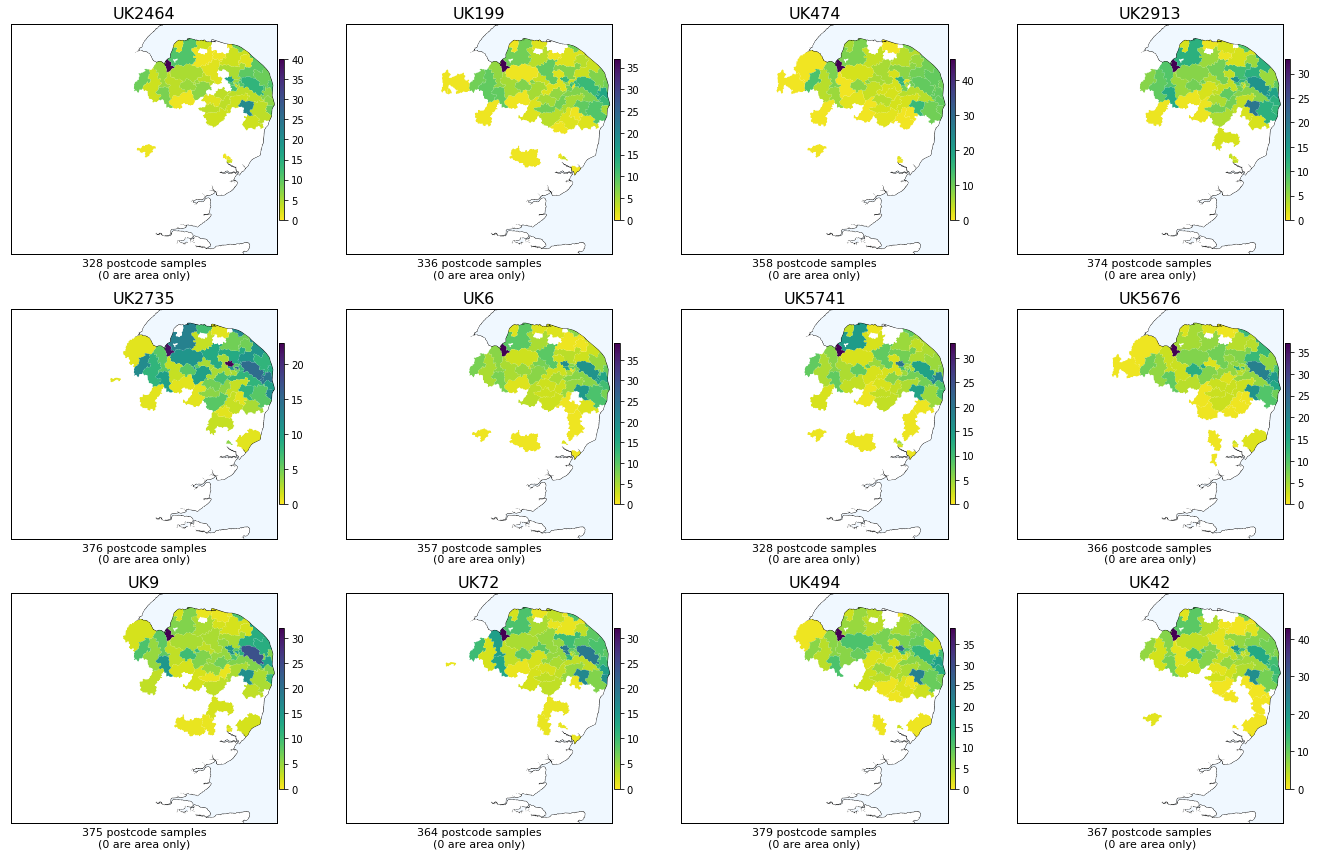

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=4,figsize=(20,12)) # I'm leaving ax in case we want several plots
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

# idisplay limits to 20 figures 
for i in range(12):
    make_map_density (df0, nor_lineages[i], fig, ax[i%3,int(i/3)])
fig.tight_layout()